**This code is running with the following key libraries version and TPU hardware accelerator on Google colab, to reproduce the code output one may need to downgrade the tensorflow version to <= 2.12**

In [ ]:
!pip show tensorflow
!pip show keras
!python --version

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras
Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow
Python 3.10.12


In [1]:
import re
import warnings
import string
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# !pip uninstall tensorflow
# !pip install tensorflow==2.12.0
!pip show tensorflow

import tensorflow as tf
from tensorflow import keras
from keras import initializers, preprocessing, layers
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import SpatialDropout1D
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.layers import TextVectorization
from nltk.tokenize import word_tokenize
from collections import Counter
import tensorflow_hub as hub
import numpy as np
# note using the new ConfusionMatrixDisplay to replace the deprecated plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
# use RocCurveDisplay to replace plot_roc_curve
from sklearn.metrics import roc_curve, RocCurveDisplay, accuracy_score

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [2]:
import os

# Config TF 1.x on google colab to speed up training
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  ['10.16.232.114:8470']


REPLICAS:  8


**Data preprocessing**

In [3]:
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Download stopwords and punkt tokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set up SSL context to avoid certificate verification errors
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Function to preprocess text data
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and (not word.isnumeric())]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tweet = ' '.join(tokens)
    # tweet = lemmatization(tweet)
    return tweet


reddit_data = pd.read_csv('Reddit_Data.csv').dropna()
twitter_data = pd.read_csv('Twitter_Data.csv').dropna()


# Read data input

reddit_data.columns = ['messages', 'labels']
twitter_data.columns = ['messages', 'labels']

# Concatenate data from Reddit and Twitter
df = pd.concat([reddit_data, twitter_data], ignore_index=True)

# Preprocess messages
df["clean_comment"] = df['messages'].apply(preprocess)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Tokenization**

In [12]:
tokenizer_long = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_long.fit_on_texts(df['clean_comment'].values)
word_index = tokenizer_long.word_index
print('Found %s unique tokens.' % len(word_index))

Found 109120 unique tokens.


In [13]:
maxlong = 3000
X_long = tokenizer_long.texts_to_sequences(df['clean_comment'].values)
X_long = pad_sequences(X_long, maxlen=maxlong)

In [14]:
Y_long = pd.get_dummies(df['labels'],columns=df["labels"]).values
lb = LabelBinarizer().fit(list(set(df['labels'].tolist())))

**Split training and testing data**

In [15]:
from sklearn.model_selection import train_test_split

train_x_long, test_x_long , train_y_long, test_y_long = train_test_split(X_long, Y_long, test_size=.1)

**Model 1: LSTM**

In [18]:
from keras import layers
with strategy.scope():
  model1 = Sequential()
  model1.add(layers.Embedding(50000, 20)) # embedding layer
  model1.add(layers.LSTM(15,dropout=0.5)) # LSTM layer
  model1.add(layers.Dense(3,activation='softmax'))
  model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
  model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          1000000   
                                                                 
 lstm (LSTM)                 (None, 15)                2160      
                                                                 
 dense (Dense)               (None, 3)                 48        
                                                                 
Total params: 1,002,208
Trainable params: 1,002,208
Non-trainable params: 0
_________________________________________________________________


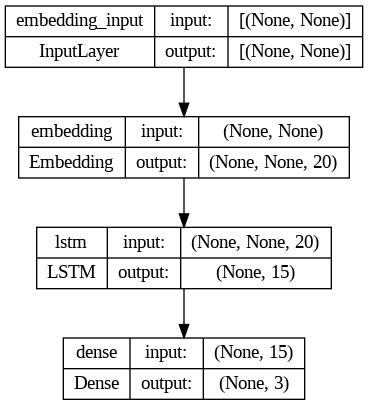

In [19]:
from keras.utils import plot_model
plot_model(model1, show_shapes=True, show_layer_names=True)

In [23]:
checkpoint_long = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(train_x_long, train_y_long, epochs=5, batch_size =72,validation_split=0.15,callbacks=[checkpoint_long])

Epoch 1/5
2127/2127 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.6240
Epoch 1: val_accuracy improved from -inf to 0.75241, saving model to best_model1.hdf5
2127/2127 [==============================] - 2251s 1s/step - loss: 0.8348 - accuracy: 0.6240 - val_loss: 0.6158 - val_accuracy: 0.7524
Epoch 2/5
2127/2127 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7756
Epoch 2: val_accuracy improved from 0.75241 to 0.82810, saving model to best_model1.hdf5
2127/2127 [==============================] - 2235s 1s/step - loss: 0.5696 - accuracy: 0.7756 - val_loss: 0.4796 - val_accuracy: 0.8281
Epoch 3/5
2127/2127 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.8238
Epoch 3: val_accuracy improved from 0.82810 to 0.84580, saving model to best_model1.hdf5
2127/2127 [==============================] - 2236s 1s/step - loss: 0.4753 - accuracy: 0.8238 - val_loss: 0.4378 - val_accuracy: 0.8458
Epoch 4/5
2127/2127 [===================

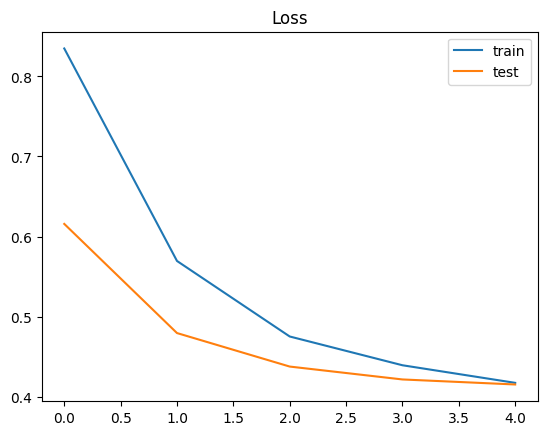

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

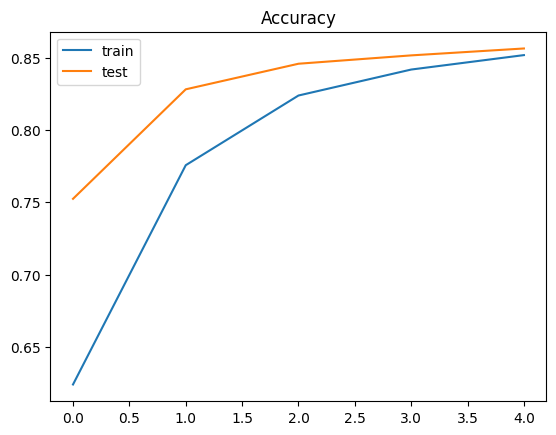

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

626/626 [==============================] - 29s 44ms/step


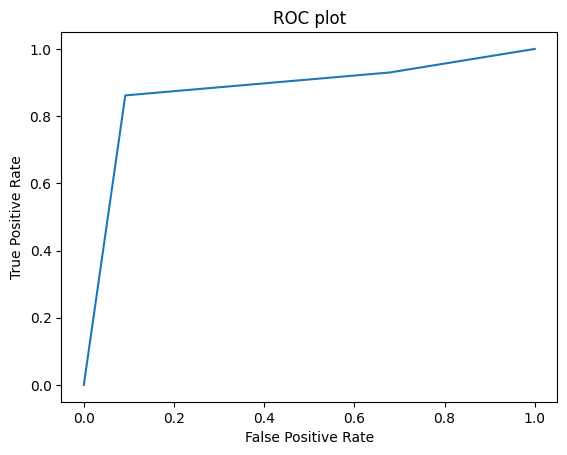

In [28]:
#ROC Curve
fpr, tpr, _ = roc_curve(test_y_long.argmax(axis=1),model1.predict(test_x_long).argmax(axis=1), pos_label=2)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

626/626 [==============================] - 27s 43ms/step


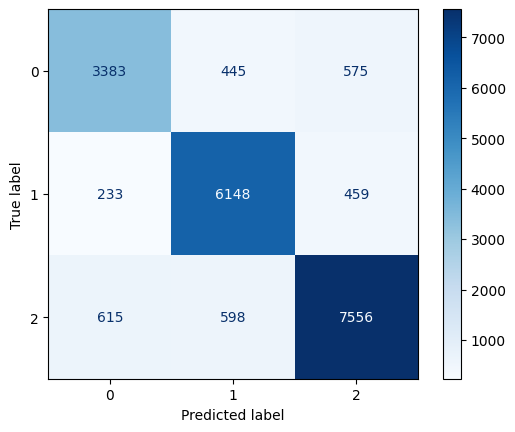

In [30]:
# Confusion Matrix
cm_rm_2 = confusion_matrix((test_y_long).argmax(axis=1),model1.predict(test_x_long).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Model 2: Bi-LSTM that with same parameters as model 1(LSTM)**

In [32]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_y_long.argmax(axis=1),model1.predict(test_x_long).argmax(axis=1)))

626/626 [==============================] - 26s 41ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4403
           1       0.85      0.90      0.88      6840
           2       0.88      0.86      0.87      8769

    accuracy                           0.85     20012
   macro avg       0.84      0.84      0.84     20012
weighted avg       0.85      0.85      0.85     20012



In [20]:
with strategy.scope():
  model2 = Sequential()
  model2.add(layers.Embedding(5000, 20))
  model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.5)))
  model2.add(layers.Dense(3,activation='softmax'))
  model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
  model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               6560      
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 3)                 123       
                                                                 
Total params: 106,683
Trainable params: 106,683
Non-trainable params: 0
_________________________________________________________________


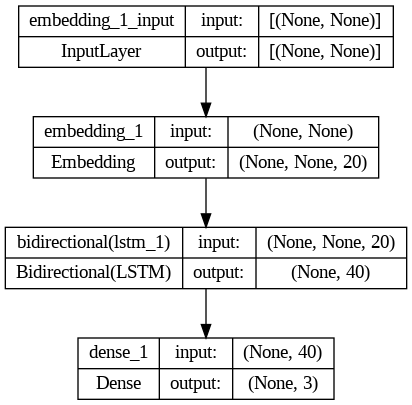

In [21]:
plot_model(model2, show_shapes=True, show_layer_names=True)

In [35]:
checkpoint_long2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history_long2 = model2.fit(train_x_long, train_y_long, epochs=5, batch_size =72,validation_split=0.15,callbacks=[checkpoint_long2])

Epoch 1/5
2127/2127 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7277
Epoch 1: val_accuracy improved from -inf to 0.82825, saving model to best_model2.hdf5
2127/2127 [==============================] - 1235s 577ms/step - loss: 0.6551 - accuracy: 0.7277 - val_loss: 0.4712 - val_accuracy: 0.8282
Epoch 2/5
2127/2127 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.8329
Epoch 2: val_accuracy improved from 0.82825 to 0.84487, saving model to best_model2.hdf5
2127/2127 [==============================] - 1218s 573ms/step - loss: 0.4651 - accuracy: 0.8329 - val_loss: 0.4371 - val_accuracy: 0.8449
Epoch 3/5
2127/2127 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.8459
Epoch 3: val_accuracy improved from 0.84487 to 0.85246, saving model to best_model2.hdf5
2127/2127 [==============================] - 1218s 573ms/step - loss: 0.4377 - accuracy: 0.8459 - val_loss: 0.4231 - val_accuracy: 0.8525
Epoch 4/5
2127/2127 [==========

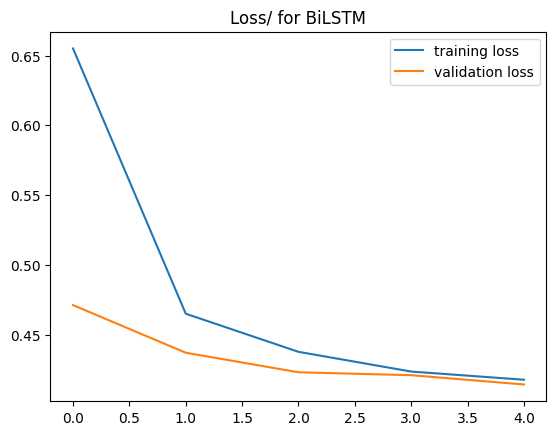

In [43]:
plt.title('Loss/ for BiLSTM')
plt.plot(history_long2.history['loss'], label='training loss')
plt.plot(history_long2.history['val_loss'], label='validation loss')
plt.legend()
plt.show();

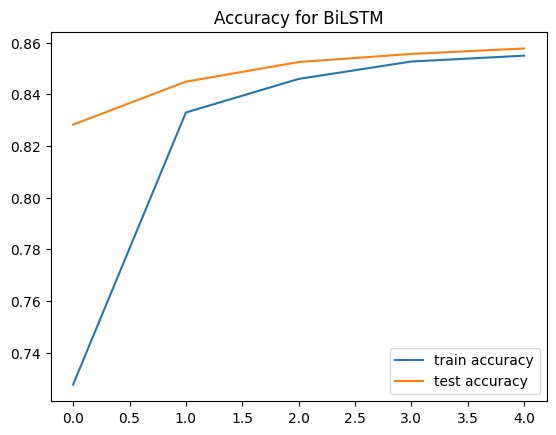

In [44]:
plt.title('Accuracy for BiLSTM')
plt.plot(history_long2.history['accuracy'], label='train accuracy')
plt.plot(history_long2.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show();

626/626 [==============================] - 46s 72ms/step


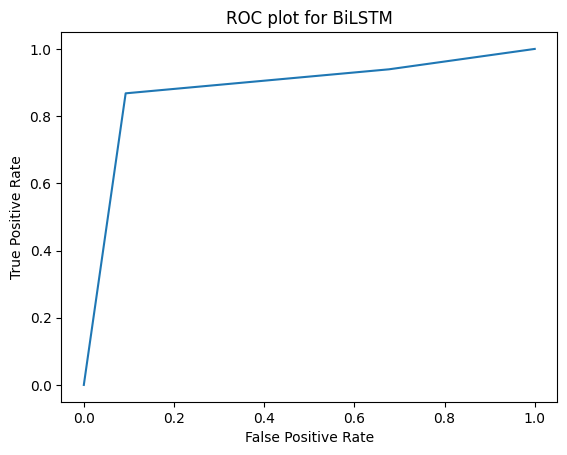

In [38]:
#ROC Curve
fpr, tpr, _ = roc_curve(test_y_long.argmax(axis=1),model2.predict(test_x_long).argmax(axis=1), pos_label=2)
plt.plot(fpr,tpr)
plt.title("ROC plot for BiLSTM")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

626/626 [==============================] - 44s 70ms/step


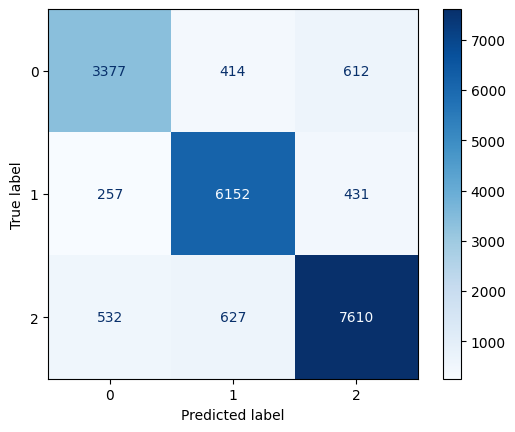

In [39]:
# Confusion Matrix
cm_rm_2 = confusion_matrix((test_y_long).argmax(axis=1),model2.predict(test_x_long).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [40]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_y_long.argmax(axis=1),model2.predict(test_x_long).argmax(axis=1)))

626/626 [==============================] - 45s 71ms/step
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      4403
           1       0.86      0.90      0.88      6840
           2       0.88      0.87      0.87      8769

    accuracy                           0.86     20012
   macro avg       0.85      0.84      0.85     20012
weighted avg       0.86      0.86      0.86     20012



**Model 3: Bi-LSTM2, improved from model 2 Bi-LSTM with parameter tuning on dropout rate and epochs**

In [14]:
from keras.callbacks import ModelCheckpoint
from keras import layers
with strategy.scope():
  model3 = Sequential()
  model3.add(layers.Embedding(5000, 20))
  model3.add(layers.Bidirectional(layers.LSTM(20,dropout=0.4)))
  model3.add(layers.Dense(3,activation='softmax'))
  model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
  model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               6560      
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 123       
                                                                 
Total params: 106,683
Trainable params: 106,683
Non-trainable params: 0
_________________________________________________________________


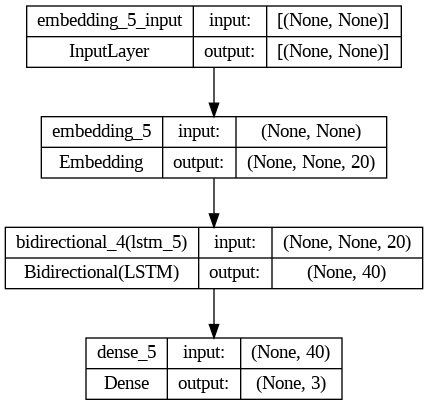

In [30]:
plot_model(model3, show_shapes=True, show_layer_names=True)

In [31]:
from keras.callbacks import ModelCheckpoint
checkpoint_long3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history_long3 = model3.fit(train_x_long, train_y_long, epochs=6, batch_size=72, validation_split=0.15, callbacks=[checkpoint_long3])

Epoch 1/6
2127/2127 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7413
Epoch 1: val_accuracy improved from -inf to 0.83876, saving model to best_model3.hdf5
2127/2127 [==============================] - 1235s 577ms/step - loss: 0.6299 - accuracy: 0.7413 - val_loss: 0.4532 - val_accuracy: 0.8388
Epoch 2/6
2127/2127 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8420
Epoch 2: val_accuracy improved from 0.83876 to 0.84987, saving model to best_model3.hdf5
2127/2127 [==============================] - 1217s 572ms/step - loss: 0.4460 - accuracy: 0.8420 - val_loss: 0.4360 - val_accuracy: 0.8499
Epoch 3/6
2127/2127 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.8524
Epoch 3: val_accuracy improved from 0.84987 to 0.85816, saving model to best_model3.hdf5
2127/2127 [==============================] - 1220s 573ms/step - loss: 0.4231 - accuracy: 0.8524 - val_loss: 0.4122 - val_accuracy: 0.8582
Epoch 4/6
2127/2127 [==========

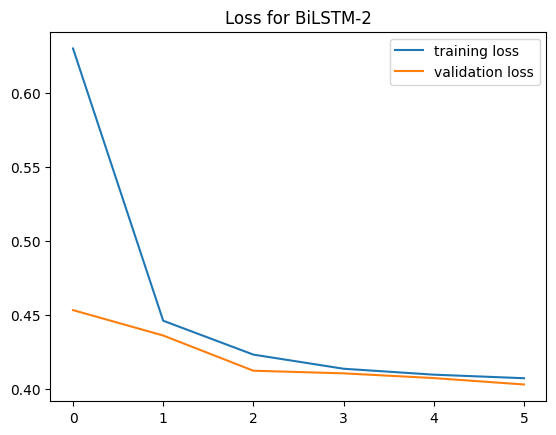

In [32]:
plt.title('Loss for BiLSTM-2')
plt.plot(history_long3.history['loss'], label='training loss')
plt.plot(history_long3.history['val_loss'], label='validation loss')
plt.legend()
plt.show();12

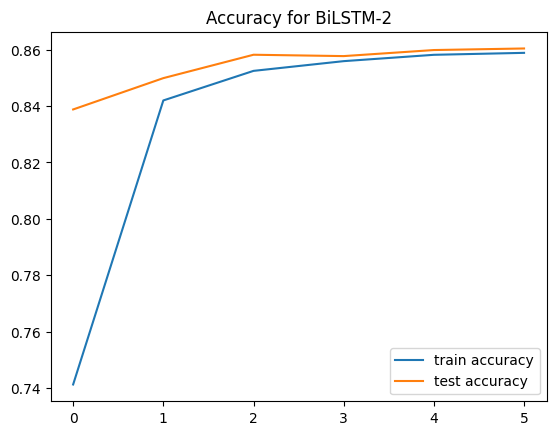

In [33]:
plt.title('Accuracy for BiLSTM-2')
plt.plot(history_long3.history['accuracy'], label='train accuracy')
plt.plot(history_long3.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show();

626/626 [==============================] - 44s 69ms/step


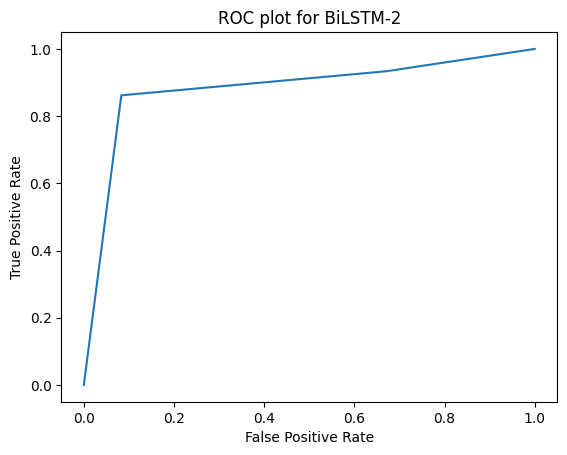

In [36]:
#ROC Curve
fpr, tpr, _ = roc_curve(test_y_long.argmax(axis=1),model3.predict(test_x_long).argmax(axis=1), pos_label=2)
plt.plot(fpr,tpr)
plt.title("ROC plot for BiLSTM-2")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

626/626 [==============================] - 44s 69ms/step


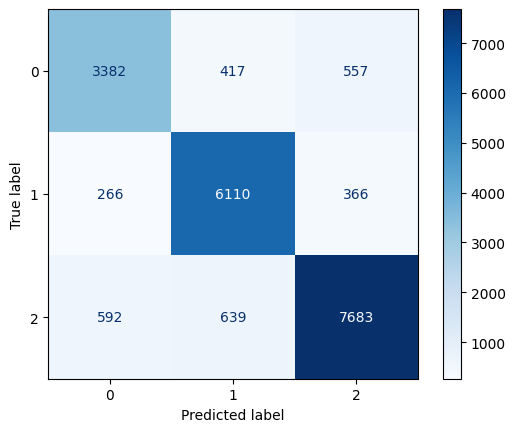

In [37]:
# Confusion Matrix
cm_rm_2 = confusion_matrix((test_y_long).argmax(axis=1),model3.predict(test_x_long).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [39]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_y_long.argmax(axis=1),model3.predict(test_x_long).argmax(axis=1)))

626/626 [==============================] - 44s 69ms/step
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      4356
           1       0.85      0.91      0.88      6742
           2       0.89      0.86      0.88      8914

    accuracy                           0.86     20012
   macro avg       0.85      0.85      0.85     20012
weighted avg       0.86      0.86      0.86     20012



**Re-process data and keeping the stopwords**

In [4]:
# Function to preprocess text data
def preprocess_includeStopWords(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(tweet)
    # stop_words = set(stopwords.words('english'))
    # tokens = [word for word in tokens if word not in stop_words and (not word.isnumeric())]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tweet = ' '.join(tokens)
    # tweet = lemmatization(tweet)
    return tweet

reddit_data_new = pd.read_csv('Reddit_Data.csv').dropna()
twitter_data_new = pd.read_csv('Twitter_Data.csv').dropna()


reddit_data_new.columns = ['messages', 'labels']
twitter_data_new.columns = ['messages', 'labels']

# Concatenate data from Reddit and Twitter
df_new = pd.concat([reddit_data_new, twitter_data_new], ignore_index=True)

# Preprocess messages
df_new["clean_comment_new"] = df_new['messages'].apply(preprocess_includeStopWords)


In [6]:
tokenizer_long_new = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_long_new.fit_on_texts(df_new['clean_comment_new'].values)
word_index = tokenizer_long_new.word_index
print('Found %s unique tokens.' % len(word_index))

Found 111551 unique tokens.


In [7]:
maxlong = 3000
X_long_new = tokenizer_long_new.texts_to_sequences(df_new['clean_comment_new'].values)
X_long_new = pad_sequences(X_long_new, maxlen=maxlong)

In [8]:
Y_long_new = pd.get_dummies(df_new['labels'],columns=df_new["labels"]).values
lb = LabelBinarizer().fit(list(set(df_new['labels'].tolist())))

In [9]:
from sklearn.model_selection import train_test_split

train_x_long_new, test_x_long_new , train_y_long_new, test_y_long_new = train_test_split(X_long_new, Y_long_new, test_size=.1)

**Running the Model 3: Bi-LSTM2 on data that had stopwords kept**

In [15]:
from keras.callbacks import ModelCheckpoint
checkpoint_long4 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history_long4 = model3.fit(train_x_long_new, train_y_long_new, epochs=6, batch_size=72, validation_split=0.15, callbacks=[checkpoint_long4])

Epoch 1/6
2127/2127 [==============================] - ETA: 0s - loss: 0.5938 - accuracy: 0.7580
Epoch 1: val_accuracy improved from -inf to 0.86649, saving model to best_model3.hdf5
2127/2127 [==============================] - 1236s 578ms/step - loss: 0.5938 - accuracy: 0.7580 - val_loss: 0.3798 - val_accuracy: 0.8665
Epoch 2/6
2127/2127 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.8705
Epoch 2: val_accuracy improved from 0.86649 to 0.88211, saving model to best_model3.hdf5
2127/2127 [==============================] - 1221s 574ms/step - loss: 0.3707 - accuracy: 0.8705 - val_loss: 0.3466 - val_accuracy: 0.8821
Epoch 3/6
2127/2127 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8844
Epoch 3: val_accuracy improved from 0.88211 to 0.88925, saving model to best_model3.hdf5
2127/2127 [==============================] - 1218s 573ms/step - loss: 0.3342 - accuracy: 0.8844 - val_loss: 0.3250 - val_accuracy: 0.8893
Epoch 4/6
2127/2127 [==========

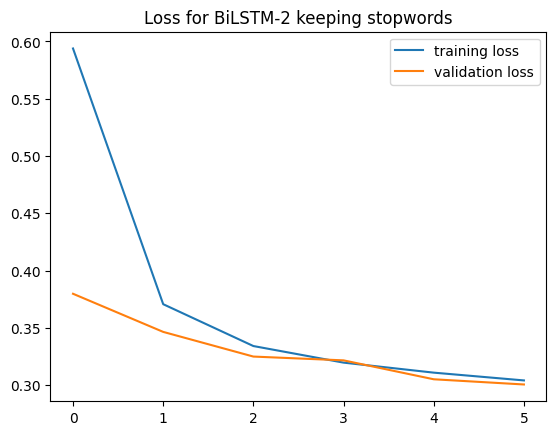

12

In [16]:
plt.title('Loss for BiLSTM-2 keeping stopwords')
plt.plot(history_long4.history['loss'], label='training loss')
plt.plot(history_long4.history['val_loss'], label='validation loss')
plt.legend()
plt.show();12

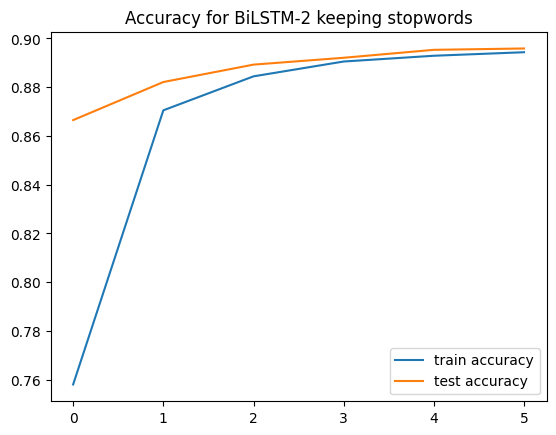

In [17]:
plt.title('Accuracy for BiLSTM-2 keeping stopwords')
plt.plot(history_long4.history['accuracy'], label='train accuracy')
plt.plot(history_long4.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show();

626/626 [==============================] - 46s 72ms/step


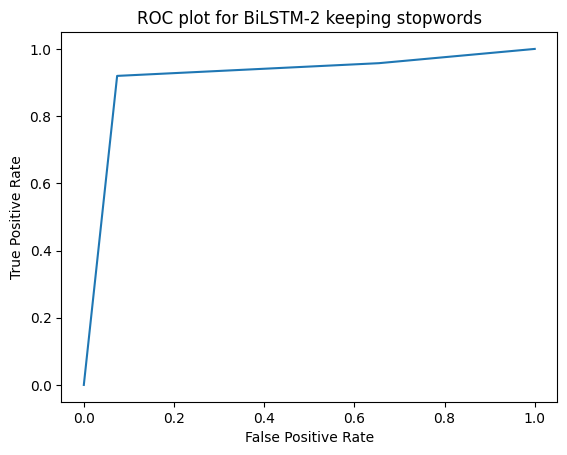

In [18]:
#ROC Curve
fpr, tpr, _ = roc_curve(test_y_long_new.argmax(axis=1),model3.predict(test_x_long_new).argmax(axis=1), pos_label=2)
plt.plot(fpr,tpr)
plt.title("ROC plot for BiLSTM-2 keeping stopwords")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

626/626 [==============================] - 45s 71ms/step


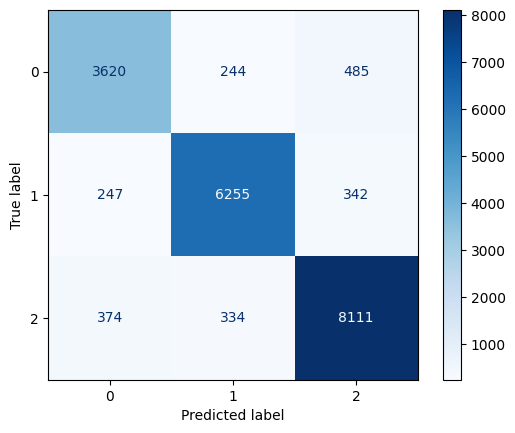

In [19]:
# Confusion Matrix
cm_rm_2 = confusion_matrix((test_y_long_new).argmax(axis=1),model3.predict(test_x_long_new).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_y_long_new.argmax(axis=1),model3.predict(test_x_long_new).argmax(axis=1)))

626/626 [==============================] - 45s 71ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4349
           1       0.92      0.91      0.91      6844
           2       0.91      0.92      0.91      8819

    accuracy                           0.90     20012
   macro avg       0.89      0.89      0.89     20012
weighted avg       0.90      0.90      0.90     20012

